# COV-19 Case Prediction
This notebook aims to create models to predict COV-19 cases in 313 different places world wild using GluonTS models.
The data set is downloaded from Kaggle(https://www.kaggle.com/c/covid19-global-forecasting-week-4).

In [25]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

In [2]:
prediction_length = 20

## Load data and preprocessing
We first load the data from files. Since the original data doesn't meet the requirements of GluonTS models, we need to do data preprocessing and generate new dataframe where each row represents a time series for a certain place.

In [3]:
total = pd.read_csv("./covid19-global-forecasting-week-4/train.csv", index_col=False)
test = pd.read_csv("./covid19-global-forecasting-week-4/test.csv", index_col=False)

In [4]:
total = total.fillna("")
total["name"] = total["Country_Region"] + "_" + total["Province_State"]
total.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,name
0,1,,Afghanistan,2020-01-22,0.0,0.0,Afghanistan_
1,2,,Afghanistan,2020-01-23,0.0,0.0,Afghanistan_
2,3,,Afghanistan,2020-01-24,0.0,0.0,Afghanistan_
3,4,,Afghanistan,2020-01-25,0.0,0.0,Afghanistan_
4,5,,Afghanistan,2020-01-26,0.0,0.0,Afghanistan_


In [5]:
test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [14]:
country_list = sorted(list(set(total["name"])))
date_list = sorted(list(set(total["Date"])))
data_dic = {"name": country_list}

for date in date_list:
    tmp = total[total["Date"]==date]
    tmp = tmp.pivot(index="name", columns="Date", values="ConfirmedCases")
    data_dic[date] = tmp[date].values
new_df = pd.DataFrame(data_dic)
new_df.head()

,name,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
0,Afghanistan_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,607.0,665.0,714.0,784.0,840.0,906.0,933.0,996.0,1026.0,1092.0
1,Albania_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,446.0,467.0,475.0,494.0,518.0,539.0,548.0,562.0,584.0,609.0
2,Algeria_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1914.0,1983.0,2070.0,2160.0,2268.0,2418.0,2534.0,2629.0,2718.0,2811.0
3,Andorra_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,638.0,646.0,659.0,673.0,673.0,696.0,704.0,713.0,717.0,717.0
4,Angola_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,19.0,19.0,19.0,19.0,19.0,24.0,24.0,24.0,24.0


In [16]:
feature_dic = {}
for date in date_list:
    
    tmp = total[total["Date"]==date]
    tmp = tmp.pivot(index="name", columns="Date", values="Fatalities")
    feature_dic[date] = tmp[date].values
feature_df = pd.DataFrame(feature_dic)
feature_df.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,21.0,23.0,25.0,30.0,30.0,30.0,33.0,36.0,36.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,23.0,24.0,25.0,26.0,26.0,26.0,26.0,26.0,26.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,293.0,313.0,326.0,336.0,348.0,364.0,367.0,375.0,384.0,392.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,29.0,31.0,33.0,33.0,35.0,35.0,36.0,37.0,37.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


## Create training dataset and train the model

In [19]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName


train_df = new_df.drop(["name"], axis=1)
train_target_values = train_df.values
train_feature_values = feature_df.values

test_target_values = train_target_values.copy()
test_feature_values = train_feature_values.copy()
train_target_values = [ts[:-prediction_length] for ts in train_df.values]
train_feature_values = [ts[:-prediction_length] for ts in feature_df.values]

start_date = [pd.Timestamp("2020-01-22", freq='1D') for _ in range(len(new_df))]
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: feature
    }
    for (target, start, feature) in zip(train_target_values,
                                         start_date,
                                         train_feature_values)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: feature
    }
    for (target, start, feature) in zip(test_target_values,
                                         start_date,
                                        test_feature_values)
], freq="D")

In [20]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

n = 50
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=n,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 25843
100%|██████████| 50/50 [00:02<00:00, 24.98it/s, avg_epoch_loss=4.07]
INFO:root:Epoch[0] Elapsed time 2.003 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.071322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.89it/s, avg_epoch_loss=2.24]
INFO:root:Epoch[1] Elapsed time 1.861 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2.236341
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.61it/s, avg_epoch_loss=1.88]
INFO:root:Epoch[2] Elapsed time 1.880 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.881768
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.86it/s, avg_epoch_loss=1.83]
INFO:root:Epoch[3] Elapsed time 1.935 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.829450
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.38it/s, avg_epoch_loss=1.77]
INFO

## Evaluate the model

In [21]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [22]:
from gluonts.evaluation import Evaluator


class M5Evaluator(Evaluator):

    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values) ** 2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSSE"] = rmsse
        return metrics

    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric, _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts


evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
Running evaluation: 100%|██████████| 313/313 [00:01<00:00, 181.09it/s]

{
    "MSE": 80071496.29932153,
    "abs_error": 12548979.0,
    "abs_target_sum": 35590829.0,
    "abs_target_mean": 5685.435942492013,
    "seasonal_error": 42.5481515289822,
    "MASE": 90.83725046951585,
    "sMAPE": 0.4673633966771535,
    "MSIS": 2432.1350354434744,
    "QuantileLoss[0.5]": 12548979.0,
    "Coverage[0.5]": 0.32555910543130995,
    "QuantileLoss[0.67]": 14066740.760000002,
    "Coverage[0.67]": 0.40942492012779547,
    "QuantileLoss[0.95]": 11940864.8,
    "Coverage[0.95]": 0.6728434504792333,
    "QuantileLoss[0.99]": 8050371.38,
    "Coverage[0.99]": 0.7733226837060703,
    "RMSE": 8948.267782052655,
    "NRMSE": 1.5738929912436044,
    "ND": 0.3525902417164826,
    "wQuantileLoss[0.5]": 0.3525902417164826,
    "wQuantileLoss[0.67]": 0.3952349848327501,
    "wQuantileLoss[0.95]": 0.3355039805338617,
    "wQuantileLoss[0.99]": 0.2261922974595506,
    "mean_wQuantileLoss": 0.3273803761356613,
    "MAE_Coverage": 0.23221246006389773,
    "MRMSSE": Infinity
}


## Plot graphs for the results

Plotting time series predictions ...


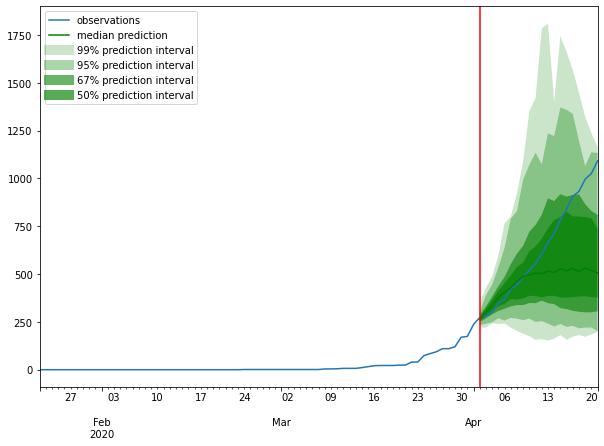

<Figure size 432x288 with 0 Axes>

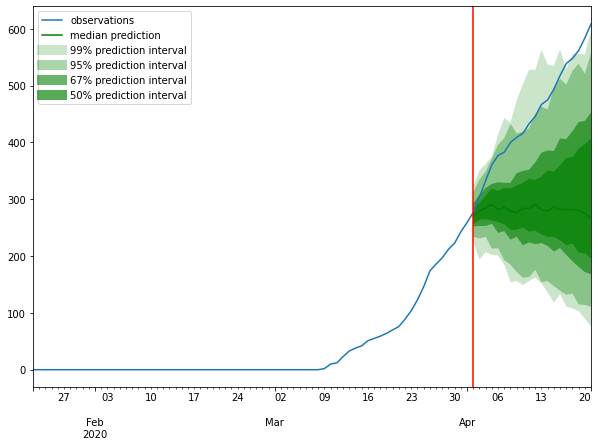

<Figure size 432x288 with 0 Axes>

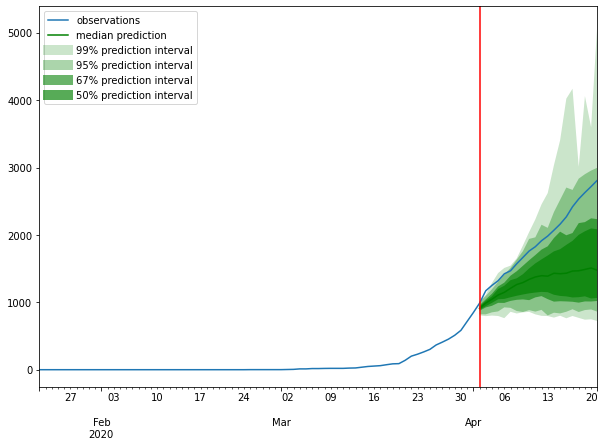

<Figure size 432x288 with 0 Axes>

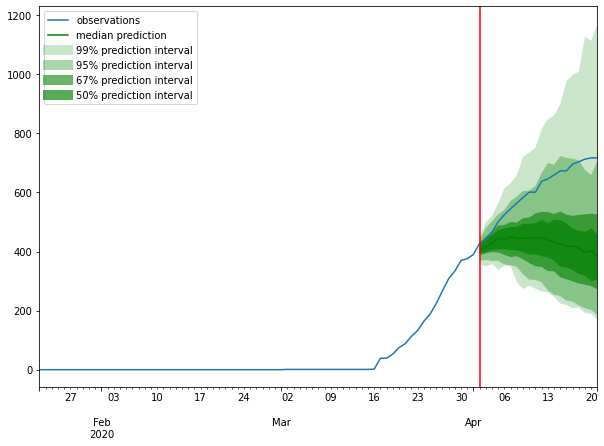

<Figure size 432x288 with 0 Axes>

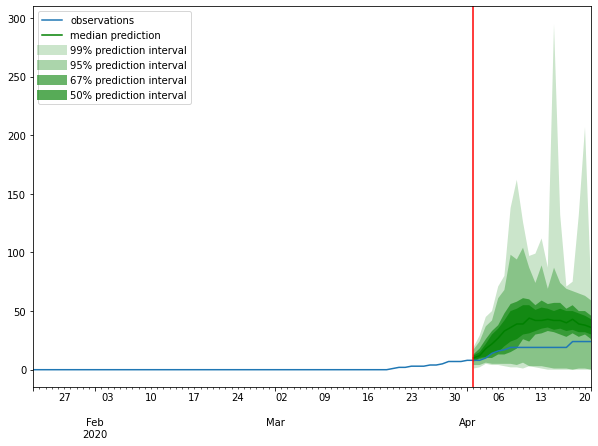

<Figure size 432x288 with 0 Axes>

In [23]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    

def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

## Comments
The result is seemingly good but there is still much space for improvements. The main problem is that the data got from kaggle contain only a few features which limits us from creating more precise models. The current is very close to a baseline model because it contains only one extra feature. The next thing to do is to find additional data on kaggle or from the internet to improve the model.